In [1]:
import boto3
import pandas as pd
from io import StringIO


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
bucket_name = 'clustertraces'
file_key = 'borg_traces_data.csv'

# Creating a boto3 client
s3 = boto3.client('s3')

# Object rtracing
response = s3.get_object(Bucket=bucket_name, Key=file_key)

# Load CSV
csv_content = response['Body'].read().decode('utf-8')

# Dataframe declaration
df = pd.read_csv(StringIO(csv_content))


df.head()

,Unnamed: 0,time,instance_events_type,collection_id,scheduling_class,collection_type,priority,alloc_collection_id,instance_index,machine_id,...,assigned_memory,page_cache_memory,cycles_per_instruction,memory_accesses_per_instruction,sample_rate,cpu_usage_distribution,tail_cpu_usage_distribution,cluster,event,failed
0,0,0,2,94591244395,3,1,200,0,144,168846390496,...,0.014435,0.000415,NaN,NaN,1.0,[0.00314331 0.00381088 0.00401306 0.00415039 0...,[0.00535583 0.00541687 0.00548553 0.00554657 0...,7,FAIL,1
1,1,2517305308183,2,260697606809,2,0,360,221495397286,335,85515092,...,0.000000,0.000000,NaN,NaN,1.0,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,[1.23977661e-05 1.23977661e-05 1.23977661e-05 ...,7,FAIL,1
2,2,195684022913,6,276227177776,2,0,103,0,376,169321752432,...,0.010422,0.000235,0.939919,0.001318,1.0,[0.01344299 0.01809692 0.0201416 0.02246094 0...,[0.02902222 0.02929688 0.0295105 0.0296936 0...,7,SCHEDULE,0
3,3,0,2,10507389885,3,0,200,0,1977,178294817221,...,0.041626,0.000225,1.359102,0.007643,1.0,[0.03704834 0.04125977 0.04290771 0.04425049 0...,[0.05535889 0.05584717 0.05633545 0.05718994 0...,8,FAIL,1
4,4,1810627494172,3,25911621841,2,0,0,0,3907,231364893292,...,0.000272,0.000010,NaN,NaN,1.0,[0. 0. 0. 0. 0...,[0.00041485 0.00041485 0.00041485 0.00041485 0...,2,FINISH,0


In [4]:
df.shape

(405894, 34)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405894 entries, 0 to 405893
Data columns (total 34 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       405894 non-null  int64  
 1   time                             405894 non-null  int64  
 2   instance_events_type             405894 non-null  int64  
 3   collection_id                    405894 non-null  int64  
 4   scheduling_class                 405894 non-null  int64  
 5   collection_type                  405894 non-null  int64  
 6   priority                         405894 non-null  int64  
 7   alloc_collection_id              405894 non-null  int64  
 8   instance_index                   405894 non-null  int64  
 9   machine_id                       405894 non-null  int64  
 10  resource_request                 405120 non-null  object 
 11  constraint                       405894 non-null  object 
 12  co

In [6]:
df.isnull().sum()

Unnamed: 0                              0
time                                    0
instance_events_type                    0
collection_id                           0
scheduling_class                        0
collection_type                         0
priority                                0
alloc_collection_id                     0
instance_index                          0
machine_id                              0
resource_request                      774
constraint                              0
collections_events_type                 0
user                                    0
collection_name                         0
collection_logical_name                 0
start_after_collection_ids              0
vertical_scaling                      959
scheduler                             959
start_time                              0
end_time                                0
average_usage                           0
maximum_usage                           0
random_sample_usage               

**Columns like cycles_per_instruction and memory_accesses_per_instruction offer little value when missing in almost all rows. These fields are likely telemetry data, and their near-total absence means the model would learn noise or constant values if we imputed them.**

In [7]:
df.drop(['cycles_per_instruction', 'memory_accesses_per_instruction'], axis=1, inplace=True)

**We impute lower perentage of missing values with median. Median handles skewed distributions better than mean, avoids outlier influence, and preserves distribution shape for classifiers**

In [8]:
df['vertical_scaling'].fillna(df['vertical_scaling'].median(), inplace=True)

**Mode imputation preserves categorical variable structure without introducing new categories.**

In [9]:
df['scheduler'].fillna(df['scheduler'].mode()[0], inplace=True)

In [10]:
df.isnull().sum()

Unnamed: 0                       0
time                             0
instance_events_type             0
collection_id                    0
scheduling_class                 0
collection_type                  0
priority                         0
alloc_collection_id              0
instance_index                   0
machine_id                       0
resource_request               774
constraint                       0
collections_events_type          0
user                             0
collection_name                  0
collection_logical_name          0
start_after_collection_ids       0
vertical_scaling                 0
scheduler                        0
start_time                       0
end_time                         0
average_usage                    0
maximum_usage                    0
random_sample_usage              0
assigned_memory                  0
page_cache_memory                0
sample_rate                      0
cpu_usage_distribution           0
tail_cpu_usage_distr

In [11]:
import ast

def safe_parse(val):
    try:
        return ast.literal_eval(val)
    except:
        return None  # Keep it None if parsing fails

# Apply to full column — DO NOT dropna()
df['resource_request'] = df['resource_request'].apply(safe_parse)

In [12]:
df['resource_request'].head()

0    {'cpus': 0.020660400390625, 'memory': 0.014434...
1    {'cpus': 0.00724029541015625, 'memory': 0.0013...
2    {'cpus': 0.048583984375, 'memory': 0.004165649...
3    {'cpus': 0.0704345703125, 'memory': 0.04162597...
4    {'cpus': 0.00244903564453125, 'memory': 0.0002...
Name: resource_request, dtype: object

In [13]:
# Extract CPU and memory if parsed successfully
df['resource_cpus'] = df['resource_request'].apply(lambda x: x.get('cpus') if isinstance(x, dict) else None)
df['resource_memory'] = df['resource_request'].apply(lambda x: x.get('memory') if isinstance(x, dict) else None)

In [14]:
# Impute the actual missing values
df['resource_cpus'].fillna(df['resource_cpus'].median(), inplace=True)
df['resource_memory'].fillna(df['resource_memory'].median(), inplace=True)

In [15]:
# Drop original
df.drop('resource_request', axis=1, inplace=True)

In [16]:
df.isnull().sum()

Unnamed: 0                     0
time                           0
instance_events_type           0
collection_id                  0
scheduling_class               0
collection_type                0
priority                       0
alloc_collection_id            0
instance_index                 0
machine_id                     0
constraint                     0
collections_events_type        0
user                           0
collection_name                0
collection_logical_name        0
start_after_collection_ids     0
vertical_scaling               0
scheduler                      0
start_time                     0
end_time                       0
average_usage                  0
maximum_usage                  0
random_sample_usage            0
assigned_memory                0
page_cache_memory              0
sample_rate                    0
cpu_usage_distribution         0
tail_cpu_usage_distribution    0
cluster                        0
event                          0
failed    

**Treating Date Time Dataset**

In [17]:
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

In [18]:
df['duration_sec'] = (df['end_time'] - df['start_time']).dt.total_seconds()

**One Hot Encoding**

In [19]:
from sklearn.preprocessing import LabelEncoder
label_cols = ['user', 'scheduler', 'cluster', 'scheduling_class', 'collection_type']
for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

**Data Visualization**

Matplotlib is building the font cache; this may take a moment.


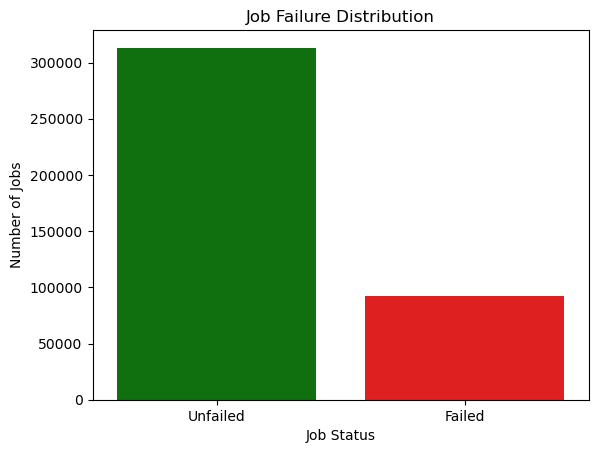

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='failed', data=df, palette=['green', 'red'])
plt.xticks([0, 1], ['Unfailed', 'Failed'])
plt.title('Job Failure Distribution')
plt.ylabel('Number of Jobs')
plt.xlabel('Job Status')
plt.show()


In [21]:
#Since in above figure we can see some imbalance, its better to checkthe count of failed jobs for treating the imbalance better
df['failed'].value_counts()

failed
0    313216
1     92678
Name: count, dtype: int64

In [22]:
failed_ratio = 92678 / (313216 + 92678) * 100
print(f"Failed connection ratio: {failed_ratio:.2f}%")

Failed connection ratio: 22.83%


## Choosing a baseline model

In [23]:
from sklearn.model_selection import train_test_split

# Drop irrelevant columns
X = df.drop(['failed', 'Unnamed: 0'], axis=1)
y = df['failed']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [24]:
#we check dtypes as our model will not process non-numeric data and we need to treat them before our prediction
df.dtypes

Unnamed: 0                              int64
time                                    int64
instance_events_type                    int64
collection_id                           int64
scheduling_class                        int64
collection_type                         int64
priority                                int64
alloc_collection_id                     int64
instance_index                          int64
machine_id                              int64
constraint                             object
collections_events_type                 int64
user                                    int64
collection_name                        object
collection_logical_name                object
start_after_collection_ids             object
vertical_scaling                      float64
scheduler                               int64
start_time                     datetime64[ns]
end_time                       datetime64[ns]
average_usage                          object
maximum_usage                     

In [25]:
numeric_cols = ['average_usage', 'maximum_usage', 'random_sample_usage']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

We can drop columns unlikely to help prediction:

In [26]:
df.drop(['constraint', 'collection_logical_name', 'collection_name',
   
         'start_after_collection_ids', 'cpu_usage_distribution',
         'tail_cpu_usage_distribution'], axis=1, inplace=True)


Since event is a useful label,we apply label encoding

In [27]:
from sklearn.preprocessing import LabelEncoder
df['event'] = LabelEncoder().fit_transform(df['event'].astype(str))


In [28]:
#confirming numeric dtypes
non_numeric = df.drop(['failed'], axis=1).select_dtypes(include=['object'])
print("Still non-numeric columns:", non_numeric.columns.tolist())

Still non-numeric columns: []


 RandomForestClassifier accepts purely numeric input (int/float) and cant process date time features

In [29]:
#Feature Engineering from Timestamps
# Hour of job start
df['start_hour'] = df['start_time'].dt.hour

# Day of week
df['start_day'] = df['start_time'].dt.dayofweek

# Time difference already calculated?
df['duration_sec'] = (df['end_time'] - df['start_time']).dt.total_seconds()


In [30]:
df.drop(['start_time', 'end_time'], axis=1, inplace=True)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop(['failed'], axis=1)
y = df['failed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62643
           1       1.00      1.00      1.00     18536

    accuracy                           1.00     81179
   macro avg       1.00      1.00      1.00     81179
weighted avg       1.00      1.00      1.00     81179



Cross Validation

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring='f1')
print(f"F1-scores across folds: {scores}")

F1-scores across folds: [1. 1. 1. 1. 1.]


## Possible Reasons for Unrealistic 100% F1-scores
Example suspect features:

event, constraint, collection_name, etc. — they might contain info about success/failure.

duration_sec or any time-derived field — if failures always have short durations, this might leak the label.

Any imputed column derived using failed indirectly (e.g., median computed separately for failed/unfailed jobs).

In [33]:
# Quick sanity check
correlations = df.corr(numeric_only=True)['failed'].sort_values(ascending=False)
print(correlations.head(10))


failed                 1.000000
scheduling_class       0.151676
duration_sec           0.141775
alloc_collection_id    0.124847
priority               0.094215
cluster                0.020874
instance_index         0.005184
time                  -0.001484
Unnamed: 0            -0.001789
machine_id            -0.008042
Name: failed, dtype: float64


## No Single Feature Has a Strong Linear Correlation
The highest correlation with failed is 0.15 (scheduling_class). The feature duration_sec is only 0.14. Everything else is close to zero

Even if numeric features aren’t leaking, categorical features might encode the label in a hidden way.

In [34]:
df.groupby('event')['failed'].mean().sort_values(ascending=False)


event
2    1.0
0    0.0
1    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: failed, dtype: float64

## Interpretation:
Every row where event == 2 has failed == 1.And, all other event values lead to failed == 0.
This means the model is simply learning the event column to determine the outcome. That’s classic target leakage. We will now drop this column

In [35]:
df.drop('event', axis=1, inplace=True)

In [36]:
#check for duplicates
print(f"Exact duplicates: {df.duplicated().sum()}")


Exact duplicates: 0


## Refitting the model again

In [37]:
#After re-adjusting our base data we will train the model again
X = df.drop(columns=['failed'])  # or drop additional non-informative columns
y = df['failed']

# Check dtypes
print(X.dtypes.value_counts())

int64      14
float64    10
int32       2
Name: count, dtype: int64


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62643
           1       1.00      1.00      1.00     18536

    accuracy                           1.00     81179
   macro avg       1.00      1.00      1.00     81179
weighted avg       1.00      1.00      1.00     81179

[[62643     0]
 [    0 18536]]


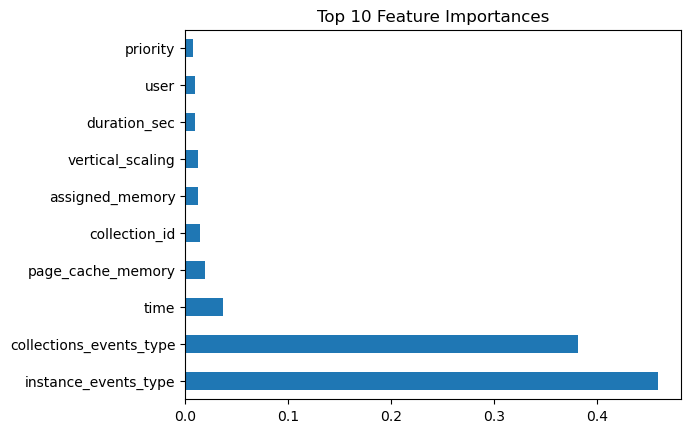

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()


In [40]:
df.resource_cpus.head(10)

0    0.020660
1    0.007240
2    0.048584
3    0.070435
4    0.002449
5    0.061523
6    0.005669
7    0.022003
8    0.008102
9    0.097168
Name: resource_cpus, dtype: float64

In [41]:
df.resource_memory.head(10)

0    0.014435
1    0.001303
2    0.004166
3    0.041626
4    0.000232
5    0.005409
6    0.001562
7    0.001501
8    0.003613
9    0.006767
Name: resource_memory, dtype: float64

Our trained model was fit on many more features, and may not work properly with just 2. So we explicitly train it on 2 features and then call a function that applies the model over our input

In [42]:
# Create a feature set with just 2 features
X_small = df[['resource_cpus', 'resource_memory']]
y = df['failed']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y, test_size=0.2, stratify=y, random_state=42
)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.75      0.83     62643
           1       0.50      0.85      0.63     18536

    accuracy                           0.77     81179
   macro avg       0.72      0.80      0.73     81179
weighted avg       0.84      0.77      0.79     81179



In [43]:
y_probs = clf.predict_proba(X_test)[:, 1]  # Probabilities for class "1" (Failed)

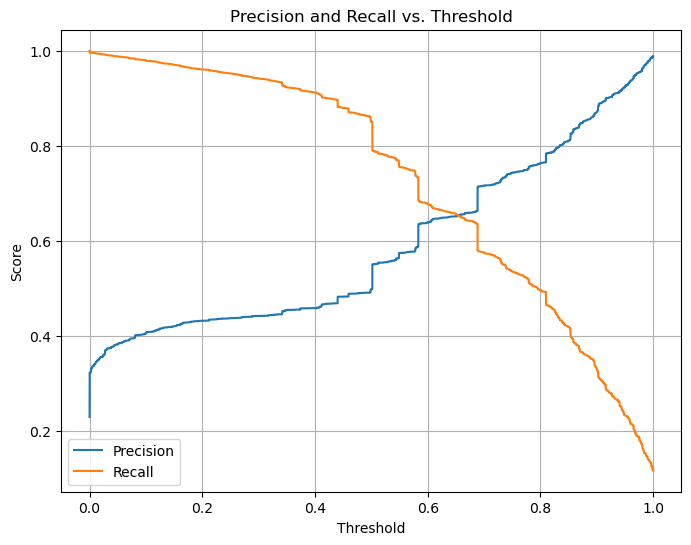

In [44]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()


In [45]:
from sklearn.metrics import f1_score
import numpy as np

best_threshold = 0
best_f1 = 0

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best threshold for max F1-score: {best_threshold:.2f}, F1-score: {best_f1:.2f}")


Best threshold for max F1-score: 0.58, F1-score: 0.66


In [46]:
threshold = 0.58

def predict_failure_verbose(cpus, memory, model, threshold=0.5):
    input_df = pd.DataFrame([{
        'resource_cpus': cpus,
        'resource_memory': memory
    }])
    
    prob = model.predict_proba(input_df)[0][1]
    label = "Failed" if prob >= threshold else "Not Failed"
    
    return {
        "Label": label,
        "Probability": round(prob, 4)
    }


In [48]:
predict_failure_verbose(0.05, 0.01, clf)

{'Label': 'Not Failed', 'Probability': 0.1417}

## Testing XGBoost

In [49]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 149.6 MB/s eta 0:00:00


In [50]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# If not scaled before, we use unscaled data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [51]:
params = {
    'max_depth': 6,
    'eta': 0.1,  # learning rate
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}


In [52]:
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=False
)


In [53]:
y_pred_proba = xgb_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


XGBoost Accuracy: 0.8186230429051848
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     62643
           1       0.74      0.32      0.44     18536

    accuracy                           0.82     81179
   macro avg       0.78      0.64      0.67     81179
weighted avg       0.81      0.82      0.79     81179

ROC AUC: 0.8472427976460121


While the model is accurate overall, its low recall on attacks suggests a bias toward the majority class which we saw in our earlier EDA stages, highlighting the need for class balancing or further tuning.

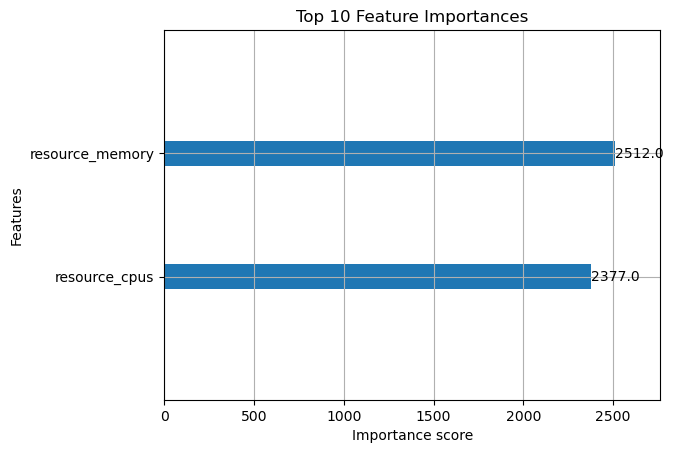

In [54]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()
